In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import pickle
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import confusion_matrix

"""
plot_history(): reads Keras result and ogenerate figure of Loss, Dice Coefficient, and Accuracy.
"""
def plot_history(history):
    loss_list = [s for s in history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.keys() if 'loss' in s and 'val' in s]
    dice_list = [s for s in history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.keys() if 'dice' in s and 'val' in s]
    acc_list = [s for s in history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history[loss_list[0]]) + 1)
    
    ## Loss
    plt.subplot(1,3,1)
    for l in loss_list:
        plt.plot(epochs, history[l], 'b', label='Training loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history[l], 'g', label='Validation loss (' + str(str(format(history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.subplot(1,3,2)
    for l in dice_list:
        plt.plot(epochs, history[l], 'b', label='Training Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history[l], 'g', label='Validation Dice Coefficient (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    plt.subplot(1,3,3)
    for l in acc_list:
        plt.plot(epochs, history[l], 'b', label='Training accuracy (' + str(format(history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history[l], 'g', label='Validation accuracy (' + str(format(history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
"""
plot_confusion_matrix(): prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          plot=False):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if plot:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

## Training from scratch evaluation (trian on top left predict top right)

In [5]:
import copy
import random
import sys
import numpy as np
from sklearn.metrics import f1_score, precision_score,recall_score
import glob

buf =30

# #prediction model from scratch
preds_test_mod = np.load('./prediction_results/prediction_result_train_from_scratch_No_NAIP_top_half_augmented_50_epochs_3_save.npy')
# print("preds_test_mod",preds_test_mod.shape)

dim = np.load('./sample/augmented_top_half/test_label.npy').shape
numr = dim[0]//(224 - buf*2)
numc = dim[1]//(224 - buf*2)

print("rows:", numr , "columns:", numc)
count = -1
for i in range(numr):

#     if(i == 15):
#         print("row: ",i,"column: ",j, "count", count)
#         break 

    for j in range(numc-1):
        count += 1    
        temp = preds_test_mod[count][buf:-buf,buf:-buf]
        if j == 0:
            rows = temp
        else:
            rows = np.concatenate((rows,temp),axis = 1)

    if i == 0:
        prediction_map = copy.copy(rows)
    else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)

prediction_map = prediction_map[:,:,0]
print("prediction_map",prediction_map.shape)

# fig= plt.figure(figsize=(20,15))
# plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=255)
# plt.show()

#print(np.unique(prediction_map))

# mask
mask = np.load('./sample/augmented_top_half/test_mask.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)
print("mask",mask.shape)

# fig= plt.figure(figsize=(35,16))
# plt.imshow(np.logical_and(prediction_map,mask), interpolation='nearest')
# plt.imshow(prediction_map, interpolation='nearest')
# plt.show()

# Read reference data
groundtruth = np.load('./sample/augmented_top_half/test_label.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
groundtruthlist = groundtruth[lr,lc]
prediction = np.logical_and(prediction_map,mask)
predictionlist = np.logical_and(prediction_map,mask)[lr,lc]
print("groundtruthlist",groundtruthlist.shape)
print("predictionlist",predictionlist.shape)

#         print(np.unique(prediction))
#         print(np.unique(groundtruth))
# #         # print(np.unique(groundtruthlist*255))
# #         # print(np.unique(predictionlist))
# #         # print(type(groundtruthlist))
# #         # print(groundtruthlist)
# #         # print(type(predictionlist))
# #         # print(predictionlist)

# #         cm = confusion_matrix((groundtruthlist).astype(int), predictionlist)
# #         plot_confusion_matrix(cm,classes=["Non-streams","Streams"])
# #         # Statistics


print('F1 score of Nonstream: '+str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('F1 score of Stream: '+str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Precision of Nonstream: '+str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Precision of Stream: '+str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Recall of Nonstream: '+str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Recall of Stream: '+str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))


        

rows: 42 columns: 43
prediction_map (6888, 6888)
mask (6888, 6888)
groundtruthlist (18814321,)
predictionlist (18814321,)
F1 score of Nonstream: 0.9876717657645866
F1 score of Stream: 0.5421977104311589
Precision of Nonstream: 0.9944079320119542
Precision of Stream: 0.43322077816915666
Recall of Nonstream: 0.9810262476782401
Recall of Stream: 0.7244279791258758


### Training from scratch (train on top left) predict bottom left

In [3]:
import copy
import random
import sys
import numpy as np
from sklearn.metrics import f1_score, precision_score,recall_score
import glob

buf =30

# #prediction model from scratch
preds_test_mod = np.load('./prediction_results/prediction_result_train_from_scratch_No_NAIP_top_half_augmented_50_epochs_3_save_btm.npy')
# print("preds_test_mod",preds_test_mod.shape)

dim = np.load('./sample/augmented_bottom_half/test_label.npy').shape
numr = dim[0]//(224 - buf*2)
numc = dim[1]//(224 - buf*2)

print("rows:", numr , "columns:", numc)
count = -1
for i in range(numr):

#     if(i == 15):
#         print("row: ",i,"column: ",j, "count", count)
#         break 

    for j in range(numc-1):
        count += 1    
        temp = preds_test_mod[count][buf:-buf,buf:-buf]
        if j == 0:
            rows = temp
        else:
            rows = np.concatenate((rows,temp),axis = 1)

    if i == 0:
        prediction_map = copy.copy(rows)
    else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)

prediction_map = prediction_map[:,:,0]
print("prediction_map",prediction_map.shape)

# fig= plt.figure(figsize=(20,15))
# plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=255)
# plt.show()

#print(np.unique(prediction_map))

# mask
mask = np.load('./sample/augmented_bottom_half/test_mask.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)
print("mask",mask.shape)

# fig= plt.figure(figsize=(35,16))
# plt.imshow(np.logical_and(prediction_map,mask), interpolation='nearest')
# plt.imshow(prediction_map, interpolation='nearest')
# plt.show()

# Read reference data
groundtruth = np.load('./sample/augmented_bottom_half/test_label.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
groundtruthlist = groundtruth[lr,lc]
prediction = np.logical_and(prediction_map,mask)
predictionlist = np.logical_and(prediction_map,mask)[lr,lc]
print("groundtruthlist",groundtruthlist.shape)
print("predictionlist",predictionlist.shape)

#         print(np.unique(prediction))
#         print(np.unique(groundtruth))
# #         # print(np.unique(groundtruthlist*255))
# #         # print(np.unique(predictionlist))
# #         # print(type(groundtruthlist))
# #         # print(groundtruthlist)
# #         # print(type(predictionlist))
# #         # print(predictionlist)

# #         cm = confusion_matrix((groundtruthlist).astype(int), predictionlist)
# #         plot_confusion_matrix(cm,classes=["Non-streams","Streams"])
# #         # Statistics


print('F1 score of Nonstream: '+str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('F1 score of Stream: '+str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Precision of Nonstream: '+str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Precision of Stream: '+str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Recall of Nonstream: '+str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Recall of Stream: '+str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))


        

rows: 42 columns: 43
prediction_map (6888, 6888)
mask (6888, 6888)
groundtruthlist (15179891,)
predictionlist (15179891,)
F1 score of Nonstream: 0.9856052934773699
F1 score of Stream: 0.4892071114572141
Precision of Nonstream: 0.9949321144699413
Precision of Stream: 0.36709458898896585
Recall of Nonstream: 0.9764517138406994
Recall of Stream: 0.7330548152416625


### Transfer on bottom right predict bottom left

In [4]:
import copy
import random
import sys
import numpy as np
from sklearn.metrics import f1_score, precision_score,recall_score
import glob

buf =30

# #prediction model from scratch
preds_test_mod = np.load('./prediction_results/prediction_result_transfered_No_NAIP_bottom_half_augmented_50_epochs_3.npy')
# print("preds_test_mod",preds_test_mod.shape)

dim = np.load('./sample/augmented_bottom_half/test_label.npy').shape
numr = dim[0]//(224 - buf*2)
numc = dim[1]//(224 - buf*2)

print("rows:", numr , "columns:", numc)
count = -1
for i in range(numr):

#     if(i == 15):
#         print("row: ",i,"column: ",j, "count", count)
#         break 

    for j in range(numc-1):
        count += 1    
        temp = preds_test_mod[count][buf:-buf,buf:-buf]
        if j == 0:
            rows = temp
        else:
            rows = np.concatenate((rows,temp),axis = 1)

    if i == 0:
        prediction_map = copy.copy(rows)
    else:
        prediction_map = np.concatenate((prediction_map,rows),axis = 0)

prediction_map = prediction_map[:,:,0]
print("prediction_map",prediction_map.shape)

# fig= plt.figure(figsize=(20,15))
# plt.imshow(prediction_map*255,cmap='gray',vmin=0, vmax=255)
# plt.show()

#print(np.unique(prediction_map))

# mask
mask = np.load('./sample/augmented_bottom_half/test_mask.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
[lr,lc] = np.where(mask == 1)
print("mask",mask.shape)

# fig= plt.figure(figsize=(35,16))
# plt.imshow(np.logical_and(prediction_map,mask), interpolation='nearest')
# plt.imshow(prediction_map, interpolation='nearest')
# plt.show()

# Read reference data
groundtruth = np.load('./sample/augmented_bottom_half/test_label.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
groundtruthlist = groundtruth[lr,lc]
prediction = np.logical_and(prediction_map,mask)
predictionlist = np.logical_and(prediction_map,mask)[lr,lc]
print("groundtruthlist",groundtruthlist.shape)
print("predictionlist",predictionlist.shape)

#         print(np.unique(prediction))
#         print(np.unique(groundtruth))
# #         # print(np.unique(groundtruthlist*255))
# #         # print(np.unique(predictionlist))
# #         # print(type(groundtruthlist))
# #         # print(groundtruthlist)
# #         # print(type(predictionlist))
# #         # print(predictionlist)

# #         cm = confusion_matrix((groundtruthlist).astype(int), predictionlist)
# #         plot_confusion_matrix(cm,classes=["Non-streams","Streams"])
# #         # Statistics


print('F1 score of Nonstream: '+str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('F1 score of Stream: '+str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Precision of Nonstream: '+str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Precision of Stream: '+str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Recall of Nonstream: '+str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Recall of Stream: '+str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))


        

rows: 42 columns: 43
prediction_map (6888, 6888)
mask (6888, 6888)
groundtruthlist (15179891,)
predictionlist (15179891,)
F1 score of Nonstream: 0.9915230924657242
F1 score of Stream: 0.5704998604502352
Precision of Nonstream: 0.9925994356267712
Precision of Stream: 0.540788013318535
Recall of Nonstream: 0.9904490810805443
Recall of Stream: 0.6036663545343226


In [13]:
# Statistics
from sklearn.metrics import f1_score, precision_score,recall_score
#print(f1_score(groundtruthlist, predictionlist, average='macro'))
# print('F1 score of nonstream: '+str(f1_score(groundtruthlist, predictionlist,pos_label=0)))
# print('Precision of stream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=1)))
# print('Precision of nonstream: '+str(precision_score(groundtruthlist, predictionlist,pos_label=0)))
# print('Recall of stream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=1)))
# print('Recall of nonstream: '+str(recall_score(groundtruthlist, predictionlist,pos_label=0)))


print('F1 score of Nonstream: '+str(f1_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('F1 score of Stream: '+str(f1_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Precision of Nonstream: '+str(precision_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Precision of Stream: '+str(precision_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

print('Recall of Nonstream: '+str(recall_score(groundtruthlist, predictionlist,labels=[0], average = 'micro')))
print('Recall of Stream: '+str(recall_score(groundtruthlist, predictionlist,labels=[1], average = 'micro')))

F1 score of Nonstream: 0.9875452274378188
F1 score of Stream: 0.5350544091806416
Precision of Nonstream: 0.9944551216513903
Precision of Stream: 0.4248521772554279
Recall of Nonstream: 0.980730696328183
Recall of Stream: 0.7224505647123147


In [11]:
import glob
model_paths = glob.glob('./vary_small_samples/Prediction_results/10/*')
model_paths

['./vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r10_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r1_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r2_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r3_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r4_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r5_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r6_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r7_.npy',
 './vary_small_samples/Prediction_results/10\\prediction_result__fine_tuning_No_NAIP_10_samples_r8_.npy',
 './vary_small_samples/Prediction_results/10\

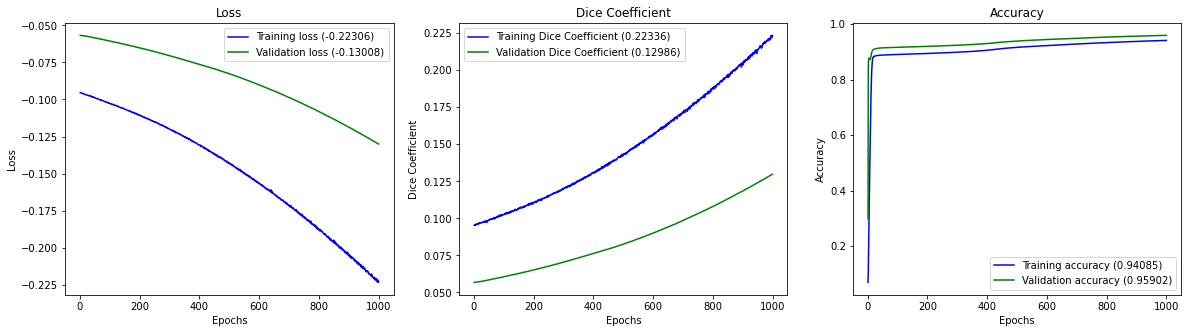

In [6]:
root_path = 'training_results/'
#infile = open(root_path+'history_attention2_transfered_08082020.pickle','rb')
infile = open(root_path+'history_transfered_NAIP_dropout_0.7_20200928-121219.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

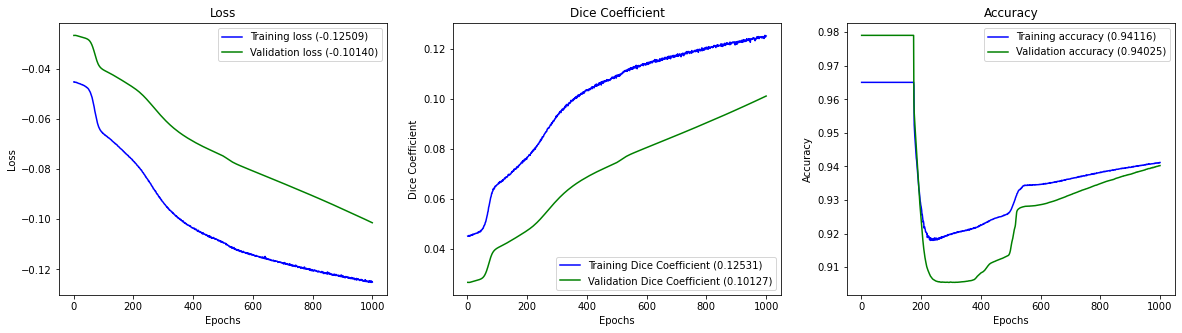

In [5]:
root_path = 'training_results/'
#infile = open(root_path+'history_attention2_transfered_08082020.pickle','rb')
infile = open(root_path+'history_transfered_NAIP_dropout_0.5_20200928-024822.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

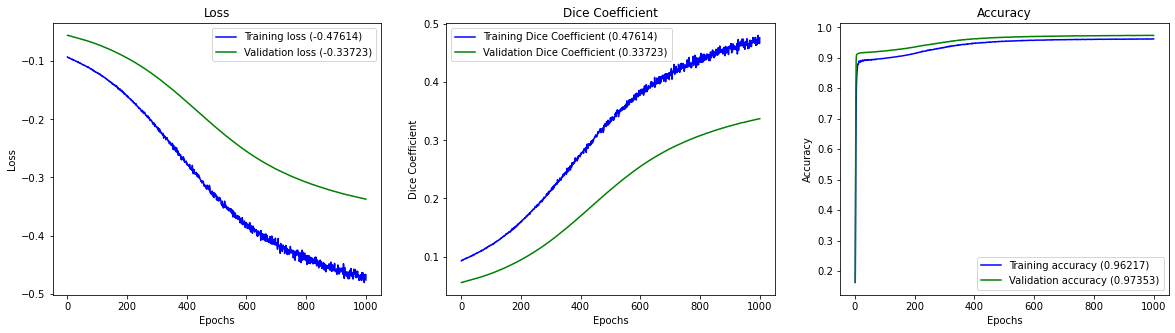

In [7]:
root_path = 'training_results/'
#infile = open(root_path+'history_attention2_transfered_08082020.pickle','rb')
infile = open(root_path+'history_attention2_transfered_NAIP_08082020.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

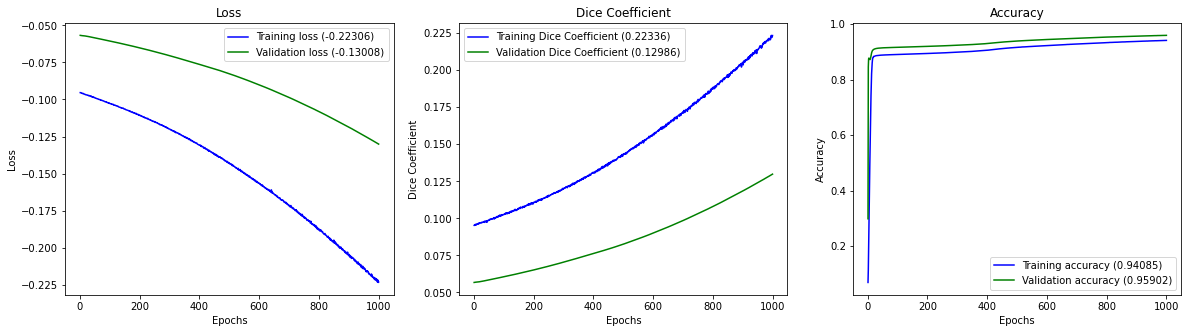

In [4]:
root_path = 'training_results/'
#infile = open(root_path+'history_attention2_transfered_08082020.pickle','rb')
infile = open(root_path+'history_transfered_NAIP_dropout_0.3_20200831-173819.pickle','rb')
new_dict = pickle.load(infile)
infile.close()
plt.figure(figsize=(20,5))
plot_history(new_dict)

In [4]:
# Generate prediction map
import gdal    
import numpy as np
import numpy.ma as ma
import copy
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(50,50),dpi=72)

# Plot the map
prediction_map_plt = prediction_map
plt.subplot(2,1,1)
plt.title('result',fontsize = 16)
plt.imshow(prediction_map_plt*255,cmap='gray',vmin=0, vmax=1)

reference = np.load('Covington_data/Total_data/reference.npy')[:prediction_map.shape[0],:prediction_map.shape[1]]
plt.subplot(2,1,2)
plt.title('Reference map',fontsize = 16)
plt.imshow(reference*255,cmap='gray',vmin=0, vmax=255)
plt.show()

ModuleNotFoundError: No module named 'osgeo.gdal'